In [1]:
import torch
import numpy as np
# 特征提取工具
# feature extractor
from tcpmeta import load_meta_for_lstm_from_csv,load_meta_from_csv
from statistical_feature_extractor_cc import flow_to_vector
# 如果不使用C++实现，可以用以下版本代替，不适合大量数据处理
# if not use the C++ implementation, you can use the following version, which is not suitable for large-scale data processing
# from statistical_feature_extractor import flow_to_vector
# 快速过滤阶段依赖的包
# fast filter for phase-dependent packages
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
# 精确检测模型
# accurate detection model
from time2vector import TimeEmbedding
from simple_projector import Projector
from lstm_feature_extractor import LSTM_AE
from detector import LSTM_Classifier,DNN_Classifier
# GPU可用时开启加速
# enable acceleration when GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 绘图工具
from matplotlib import pyplot as plt

# 流追踪，将元数据转化为对应的TCP流
# flow_tracking, convert metadata to corresponding TCP flows

In [2]:
# 根据样本哈希使用对应的元数据，执行流追踪
# track the flow of each sample using the corresponding metadata
lssvm_flows = dict()
telstm_flows = dict()
with open("hash.txt","r") as f:
    activate_hash = [line.strip() for line in f]
    for hash in activate_hash:
        csv_file = f"04_csv/{hash}.csv"
        # 方法可以设置使用的行数，避免处理大文件时内存不足
        # the method can set the number of rows to be used, avoid memory overflow when processing large files
        lssvm_flows[hash] = load_meta_from_csv(csv_file,0,5000000)
        telstm_flows[hash] = load_meta_for_lstm_from_csv(csv_file,0,5000000)

# 加载统计过滤模型
# load the statistical filtering model

In [3]:
fast_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2,include_bias=False)), #不添加1免得方差没法算，no bias for stable var value
    ('scaler', StandardScaler()),                              #归一化, normalize 
    ('linreg', LinearRegression())                             #带有截距的线性回归, regression with intercept
])
temp = np.load('parameter2.npz')
fast_model.steps[0][1].n_output_features_ = temp['arr_0']#特征数量, number of features
fast_model.steps[0][1]._n_out_full = temp['arr_1']#输入数量, number of input features
fast_model.steps[0][1]._max_degree = temp['arr_2']#最高次, maximum degree
fast_model.steps[0][1]._min_degree = temp['arr_3']#最低次, minimum degree
fast_model.steps[1][1].mean_ = temp['arr_4']#归一化层使用的均值, mean used in normalization
fast_model.steps[1][1].scale_ = temp['arr_5']#归一化层的缩放比例, scale used in normalization
fast_model.steps[2][1].coef_ = temp['arr_6']#多项式系数, coefficients of the polynomial
fast_model.steps[2][1].intercept_ = temp['arr_7']#在多项式特征里省略的系数, intercept in the polynomial features
# threshold = fast_model.steps[2][1].intercept_[0]
# 手动调整过滤阈值减少漏报
# shift the threshold to reduce false negatives
threshold = fast_model.steps[2][1].intercept_[0] - 0.3

# 加载精确检测模型
# load the exact detection model

In [4]:
seq_len = 25 # 检测窗口，window size
mean_gap = 0.18621279275524977 # 训练集的平均数据包间隔, mean packet gap in training
projector = Projector(input_dim=8,hidden_dim=128,layers_n=3,output_dim=64)
te = TimeEmbedding(64,mean_gap/60,mean_gap*360)
lstm_ae = LSTM_AE(embedding_dim=128,encode_dim=64,deep=4,step=seq_len)
dnn_classifier = DNN_Classifier(input_dim=64, hidden_dim=64, hidden_n=2, output_dim=2)
accu_model =  LSTM_Classifier(te, projector, lstm_ae, dnn_classifier)
accu_model = accu_model.to(device)
accu_model.load_state_dict(torch.load('lstm_classifier.weight',weights_only=True))
accu_model = accu_model.eval()

# 长流切分工具，适配精确检测模型长度为25的检测窗口
# long_flow_cut, cut long flow to fit the exact detection model with window size 25


In [5]:
def random_sample(stream,seq_len):
    ret = []
    choise_n = min(len(stream)//seq_len,10)
    for i in range(choise_n):
        cur = np.random.randint(0,len(stream)-seq_len+1)
        ret += [stream[cur:cur+seq_len]]
    return ret

# 首先进行统计过滤，对于可疑流量进行精确检测
# first, apply the statistical filtering model to filter out suspicious flows


In [6]:
pool_dict = dict()
black_list = []
distribution = []
with torch.no_grad():
    for hash in activate_hash:
        print("样本哈希",hash)
        suspicious = 0
        pool_cnt = 0
        for flow,meta in lssvm_flows[hash].items():
            # 样本长度超过seq_len，达到检测窗口
            # sample length exceeds seq_len, reach the detection window
            if len(meta) >= seq_len:
                predict = fast_model.predict([flow_to_vector(sequence) for sequence in random_sample(meta,seq_len)])
                distribution += list(predict)
                # 超出阈值的都是可疑流量
                # flows with prediction score higher than threshold are suspicious
                if predict.mean() > threshold:
                    print("可疑流,suspicious flow:",flow,len(meta),end=' ')
                    suspicious += 1
                    # 为精确检测模型准备输入数据
                    # prepare the input data for the accurate detection model
                    lstm_meta = np.array(random_sample(telstm_flows[hash][flow],seq_len))
                    check_ts = torch.from_numpy(lstm_meta[...,:1]).float().to(device)
                    check_meta = torch.from_numpy(lstm_meta[...,1:]).float().to(device)
                    _,_,outputs = accu_model(check_ts,check_meta)
                    alert = 0
                    # 将按照seq_len个元数据切段的流送入模型
                    # feed the flows cut into seq_len metadata segments into the model
                    for output in outputs.cpu().numpy():
                        if (output[0] <= output[1]):
                            # 每个段都检查一下是不是挖矿流量
                            # check each segment to see if it is mining traffic 
                            alert += 1
                    # 任何一个段是挖矿，都产生报警
                    # if any segment is mining, produce an alert
                    if alert > 0:
                        # 根据有多少段触发报警，给一个得分
                        # give a score based on how many segments trigger the alert
                        print("alert=true,score=",alert/len(lstm_meta))
                        # 记录一下矿池与样本的对应关系
                        # record the pool address and the sample flow
                        pool_dict[hash]=flow.split('-')[1]
                        black_list += [flow.split('-')[1]]
                        pool_cnt += 1
                    else:
                        # 可疑流没换行，这里补上
                        # add a line break for suspicious flows
                        print()
        # 打印当前样本的检测结果
        # print the detection results for the current sample
        print(f"可疑流,suspicious flow：{suspicious}，挖矿流,mining flow：{pool_cnt}")

样本哈希 42b9ec9a225710020107a6b5ab17af7ca832f46631835ca937e84f2529f0a3f5
可疑流,suspicious flow: 192.168.10.6:56576-87.121.84.156:3333 221 alert=true,score= 1.0
可疑流,suspicious flow：1，挖矿流,mining flow：1
样本哈希 eccb81440eb3aa2940c53c582bb0f6156ac0b697bf1312b6e7b0d145331d36dc
可疑流,suspicious flow: 192.168.10.6:59628-144.168.36.74:443 132 alert=true,score= 1.0
可疑流,suspicious flow：1，挖矿流,mining flow：1
样本哈希 5bae25736a09de5f4a0f9761d2b7bfa81ca8dba39de2a724473c9d021a65daa9
可疑流,suspicious flow: 192.168.10.6:49086-144.168.36.74:443 130 alert=true,score= 1.0
可疑流,suspicious flow：1，挖矿流,mining flow：1
样本哈希 0317ad351734e54f5a4e8db0444662d7a34553d1cb25bffa877217d254ca23ed
可疑流,suspicious flow: 192.168.10.6:38446-141.94.96.71:8080 253 alert=true,score= 1.0
可疑流,suspicious flow：1，挖矿流,mining flow：1
样本哈希 13675cca4674a8f9a8fabe4f9df4ae0ae9ef11986dd1dcc6a896912c7d527274
可疑流,suspicious flow: 192.168.10.6:44642-144.168.36.74:443 129 alert=true,score= 1.0
可疑流,suspicious flow：1，挖矿流,mining flow：1
样本哈希 902a3680bcf8e0270bba0fbc

# 将最终的检测结果做成黑名单
# make the final detection results into a blacklist


In [7]:
# 每一个样本连接的矿池IP
# show the pool IPs for each sample
for k,v in pool_dict.items():
    print(f"{k}:{v}")
# 打印矿池黑名单
# show the black_list pools
print("===black_list===")
for pool in set(black_list):
    print(pool)

42b9ec9a225710020107a6b5ab17af7ca832f46631835ca937e84f2529f0a3f5:87.121.84.156:3333
eccb81440eb3aa2940c53c582bb0f6156ac0b697bf1312b6e7b0d145331d36dc:144.168.36.74:443
5bae25736a09de5f4a0f9761d2b7bfa81ca8dba39de2a724473c9d021a65daa9:144.168.36.74:443
0317ad351734e54f5a4e8db0444662d7a34553d1cb25bffa877217d254ca23ed:141.94.96.71:8080
13675cca4674a8f9a8fabe4f9df4ae0ae9ef11986dd1dcc6a896912c7d527274:144.168.36.74:443
902a3680bcf8e0270bba0fbcdd6996c2934b55b3d9ccd2171d3eb7fadf199a9f:203.91.77.146:9200
7029b7bf7611129f442d3243fbe467bc4df7f13db452ed4a5624ed2784e80bc6:203.91.77.146:9200
850e955d317c23d88debc8a509a16cf30b0db07e0a4d98a2ba343c038c7f834e:47.86.97.224:19999
===black_list===
87.121.84.156:3333
141.94.96.71:8080
203.91.77.146:9200
144.168.36.74:443
47.86.97.224:19999


# 显示统计过滤阶段的分布
# show the distribution in fast filtering

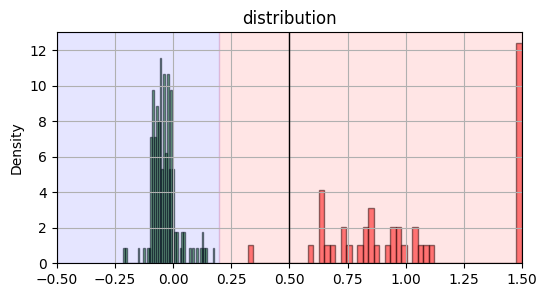

total:143
suspicious:41


In [8]:
plt.close()
fig = plt.figure(figsize=(6, 3))
distribution = np.array(distribution)
distribution[distribution>1.5]=1.5
distribution[distribution<-0.5]=-0.5
n, bins, patches1 = plt.hist(distribution[distribution<threshold], bins=50, density=True, alpha=0.5, color='g', edgecolor='black')
n, bins, patches1 = plt.hist(distribution[distribution>=threshold], bins=50, density=True, alpha=0.5, color='r', edgecolor='black')

plt.axvline(x=fast_model.steps[2][1].intercept_[0], color='k', linestyle='-', linewidth=1.0)
plt.axvspan(threshold, -0.5, color='blue', alpha=0.1)
plt.axvspan(threshold, 1.5, color='red', alpha=0.1)

plt.ylabel('Density')
plt.title('distribution')
plt.xlim(-0.5,1.5)
plt.grid(True)
plt.show()
print(f"total:{(distribution<threshold).sum()}")
print(f"suspicious:{(distribution>=threshold).sum()}")